<a href="https://colab.research.google.com/github/njuve/Cousera/blob/master/snack_analysis_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 間食分析 (c群)

In [1]:
pip install japanize-matplotlib

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import date,timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [0]:
data = pd.read_csv('data212.csv')

In [0]:
data_mean = pd.read_csv('data212_mean.csv')

In [0]:
data_sleep_q = pd.read_gbq('select * from `healthcare-1335.taberhythm_main.sleep_questionnaires`', 'healthcare-1335', dialect='standard')

In [6]:
print('data\n')
display(data.head())
print('')
print('data_mean\n')
display(data_mean.head())
print('')
print('data_sleep_q\n')
display(data_sleep_q.head())

data



,Unnamed: 0,user_id,data_type,time,time_date,sleep_at,next_wake_up_date,next_wake_up_at,next_first_meal_time,gender,age,age_per_10,bmi,bmi_rank,elapsed_time,is_lastday,is_lastday_shifted,is_lastsleep,last_sleep_time,is_unless
0,0,16,wake_up,2018-07-31 05:24:54,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,324.900000,0.0,0.0,0,2018-08-09 23:58:00,0
1,1,16,breakfast,2018-07-31 07:01:58,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,421.966667,0.0,0.0,0,2018-08-09 23:58:00,0
2,2,16,lunch,2018-07-31 12:15:08,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,735.133333,0.0,0.0,0,2018-08-09 23:58:00,0
3,3,16,dinner,2018-07-31 19:09:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,1149.000000,0.0,0.0,0,2018-08-09 23:58:00,0
4,4,16,sleep,2018-08-01 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,1440.000000,0.0,0.0,0,2018-08-09 23:58:00,0



data_mean



,Unnamed: 0,user_id,data_type,elapsed_time,gender,age_per_10,bmi,rank_bmi_3
0,0,16,breakfast,451.075000,male,40s,24.964946,normal
1,1,16,dinner,1215.533333,male,40s,24.964946,normal
2,2,16,drink,397.500000,male,40s,24.964946,normal
3,3,16,lunch,750.833333,male,40s,24.964946,normal
4,4,16,sleep,1419.626190,male,40s,24.964946,normal



data_sleep_q



,id,user_id,sleep_at,dry_eyes,eyestrain,happiness,fatigue,is_drinking,location,sunrise_at,sunset_at,created_at,updated_at
0,327,257,2018-08-04 23:00:00,20,27,70,80,False,None,NaT,NaT,2018-08-05 10:01:39,2018-08-05 10:01:39
1,1231,513,2018-08-26 23:40:28,60,50,81,40,False,None,NaT,NaT,2018-08-26 23:41:01,2018-08-26 23:41:01
2,2206,1281,2018-10-02 22:47:35,50,50,30,60,False,None,2018-10-03 05:52:13,2018-10-02 17:41:18,2018-10-02 22:50:14,2018-10-02 22:50:14
3,3108,2049,2018-10-25 00:00:00,0,15,53,0,False,None,2018-10-26 06:10:28,2018-10-25 17:11:22,2018-10-25 00:00:50,2018-10-25 00:00:50
4,3213,2049,2018-10-26 01:00:00,20,20,50,10,False,None,2018-10-27 06:12:47,2018-10-26 17:11:37,2018-10-27 00:58:41,2018-10-27 00:58:41


In [0]:
# drop columns
data = data.drop(columns = ['Unnamed: 0'])
data_mean = data_mean.drop(columns = ['Unnamed: 0'])

In [0]:
# add a time_date to data_sleep_q
data_sleep_q['time_date'] = pd.to_datetime(data_sleep_q.sleep_at - timedelta(hours = 6)).dt.date.copy()

In [0]:
data_sleep_q_essential = data_sleep_q[['user_id', 'time_date','dry_eyes', 'eyestrain', 'happiness', 'fatigue']]

アンケートは平均して扱うとして、
- 間食がある日のアンケートの平均？
- 全てのアンケートの平均？

$\to$多分全体でよい

In [0]:
sleep_q_mean  = data_sleep_q_essential.groupby('user_id').mean().reset_index()

# 間食回数

In [0]:
data_with_issnack = data.copy()

- data_with_issnack: is_snack列を追加する、間食回数カウント用

In [0]:
df_snack = data[data.data_type == 'snack'].copy()

- df_snack: スナックがある人

In [0]:
df_nosnack = data.copy()

In [0]:
nosnack_user = [user for user  in df_nosnack.user_id.values if user not in df_snack.user_id.values]

In [0]:
df_nosnack = df_nosnack[df_nosnack.user_id.isin(nosnack_user)].copy()

- df_nosnack: snackがないひと

In [0]:
data_with_issnack['is_snack'] = (data_with_issnack[['data_type']] == 'snack').copy()

In [0]:
# ユーザごとの間食回数をカウント
nsnack = data_with_issnack.groupby('user_id').is_snack.sum().to_frame().reset_index()
nsnack.columns = ['user_id', 'nsnack']

In [0]:
# ユーザごとのデータがある日にち（間食０回含む）
ndate = data_with_issnack.groupby(['user_id']).time_date.count().to_frame().reset_index().rename(columns = {'time_date':'ndate'}).copy()

In [0]:
snack_data = pd.merge(nsnack, ndate, on = 'user_id')

In [0]:
# 属性を別に持っておく　
info = data_with_issnack[['user_id', 'gender', 'age', 'age_per_10', 'bmi']].drop_duplicates(subset = ['user_id']).copy()

In [0]:
def rank_bmi_3(bmi):
  if bmi >= 25:
    return 1
  elif bmi >=20:
    return 2
  else:
    return 3

In [0]:
# bmi rankを追加
info['bmi_rank_3'] = info.bmi.apply(lambda bmi: rank_bmi_3(bmi)).copy()

In [0]:
# 属性とアンケートをくっつける
info_with_q = pd.merge(info, sleep_q_mean, on ='user_id', how ='left')

In [0]:
# 分析用
 df = pd.merge(info_with_q, snack_data, on = 'user_id', how= 'left')

In [0]:
# 平均間食回数
df['nsnack_mean'] = (df['nsnack']/df['ndate']).copy()

In [26]:
print('shape of df = {}'.format(df.shape))
print('the number of user_id = {}'.format(df.user_id.nunique()))

shape of df = (212, 13)
the number of user_id = 212


In [27]:
df.head()

,user_id,gender,age,age_per_10,bmi,bmi_rank_3,dry_eyes,eyestrain,happiness,fatigue,nsnack,ndate,nsnack_mean
0,16,male,43,40s,24.964946,2,0.800000,34.200000,35.200000,50.666667,2.0,36,0.055556
1,19,female,54,50s,19.467401,3,34.760000,38.360000,49.280000,53.160000,4.0,128,0.031250
2,20,female,42,40s,19.427976,3,28.869565,35.173913,48.000000,42.869565,0.0,10,0.000000
3,22,male,41,40s,20.861120,2,39.937500,48.843750,89.093750,88.718750,11.0,76,0.144737
4,25,female,61,50s,18.517804,3,75.935484,76.161290,57.548387,66.000000,35.0,131,0.267176


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 13 columns):
user_id        212 non-null int64
gender         212 non-null object
age            212 non-null int64
age_per_10     212 non-null object
bmi            212 non-null float64
bmi_rank_3     212 non-null int64
dry_eyes       212 non-null float64
eyestrain      212 non-null float64
happiness      212 non-null float64
fatigue        212 non-null float64
nsnack         212 non-null float64
ndate          212 non-null int64
nsnack_mean    212 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 23.2+ KB


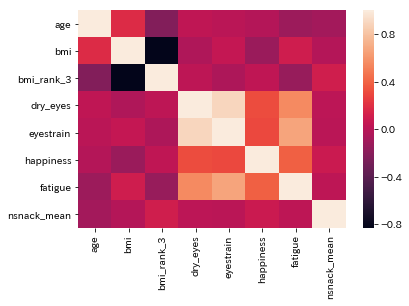

In [107]:
sns.heatmap(df.drop(columns = ['user_id', 'nsnack', 'ndate']).corr())

In [32]:
df.groupby('gender').describe()['nsnack_mean']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,141.0,0.094775,0.094389,0.0,0.0,0.074074,0.157407,0.388889
male,71.0,0.061132,0.075774,0.0,0.0,0.000000,0.138252,0.250000


Text(0.5, 0, 'スナック摂取回数')

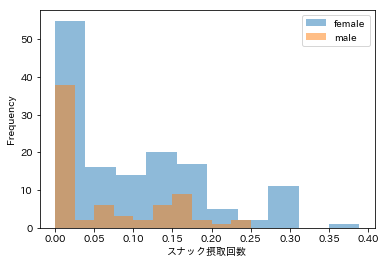

In [33]:
df.groupby('gender').nsnack_mean.plot(kind = 'hist', alpha =0.5, legend =True)
plt.xlabel('スナック摂取回数')

## 年代

In [34]:
df.groupby(['gender', 'age_per_10']).describe()['nsnack_mean']

count      mean       std  min       25%       50%  \
gender age_per_10                                                       
female 20s          62.0  0.089611  0.095352  0.0  0.000000  0.066648   
       30s          36.0  0.114659  0.102648  0.0  0.000000  0.094905   
       40s          28.0  0.076620  0.079261  0.0  0.000000  0.071921   
       50s          15.0  0.102290  0.095741  0.0  0.022406  0.097902   
male   20s          11.0  0.073661  0.078255  0.0  0.000000  0.055556   
       30s          15.0  0.061945  0.080715  0.0  0.000000  0.000000   
       40s          23.0  0.070440  0.069691  0.0  0.000000  0.065934   
       50s          22.0  0.044584  0.079543  0.0  0.000000  0.000000   

                        75%       max  
gender age_per_10                      
female 20s         0.153770  0.303030  
       30s         0.167146  0.388889  
       40s         0.131029  0.298246  
       50s         0.158845  0.275510  
male   20s         0.143807  0.192000  
       30s         0.104167  0.250000  
       40s         0.143290  0.166667  
       50s         0.043651  0.250000

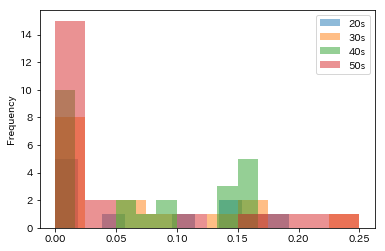

In [35]:
df[df.gender == 'male'].groupby(['age_per_10']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True);

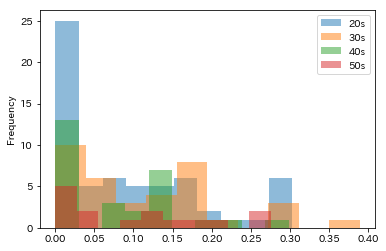

In [36]:
df[df.gender == 'female'].groupby(['age_per_10']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True);

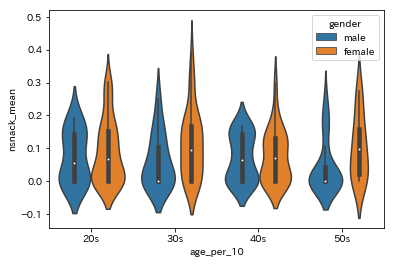

In [37]:
sns.violinplot(x = 'age_per_10', y ='nsnack_mean', hue ='gender', data =df, order = ['20s', '30s', '40s', '50s'])

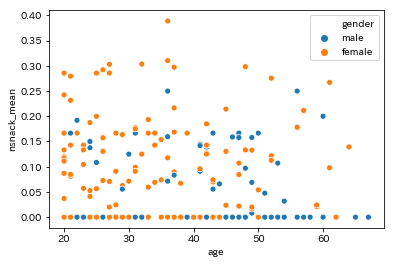

In [38]:
sns.scatterplot(x = 'age', y ='nsnack_mean', hue ='gender', data =df)

## BMI

In [39]:
df.groupby(['gender', 'bmi_rank_3']).describe()['nsnack_mean']

count      mean       std  min       25%       50%  \
gender bmi_rank_3                                                       
female 1            26.0  0.090744  0.084355  0.0  0.004098  0.094406   
       2            64.0  0.089890  0.096818  0.0  0.000000  0.072435   
       3            51.0  0.102961  0.097314  0.0  0.021811  0.074074   
male   1            33.0  0.065561  0.075373  0.0  0.000000  0.047619   
       2            29.0  0.043157  0.063299  0.0  0.000000  0.000000   
       3             9.0  0.102815  0.101416  0.0  0.000000  0.150000   

                        75%       max  
gender bmi_rank_3                      
female 1           0.142857  0.303571  
       2           0.145604  0.310345  
       3           0.165152  0.388889  
male   1           0.125000  0.250000  
       2           0.071429  0.166667  
       3           0.166667  0.250000

  男性BMI

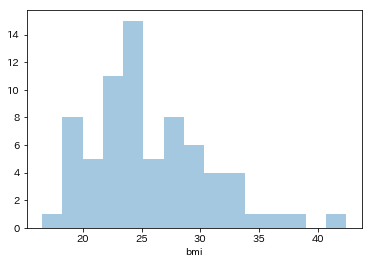

In [94]:
sns.distplot(df[df.gender == 'male'].bmi, bins = 15, kde = False)

女性BMI

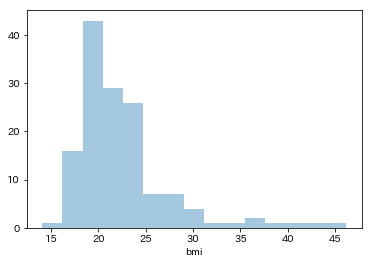

In [95]:
sns.distplot(df[df.gender == 'female'].bmi, bins = 15, kde = False)

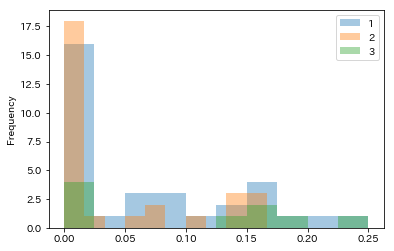

In [40]:
df[df.gender == 'male'].groupby(['bmi_rank_3']).nsnack_mean.plot(kind = 'hist', alpha = 0.4, legend = True);

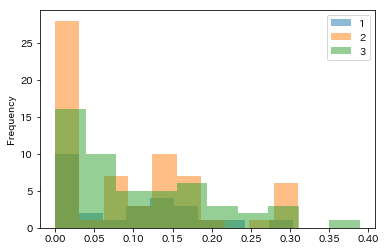

In [41]:
df[df.gender == 'female'].groupby(['bmi_rank_3']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True);

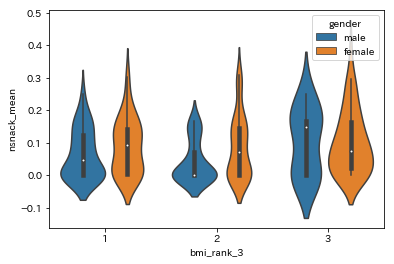

In [42]:
sns.violinplot(x = 'bmi_rank_3', y ='nsnack_mean', hue ='gender', data =df)

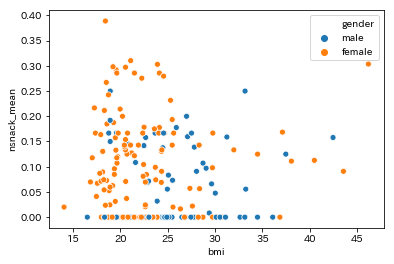

In [43]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', hue= 'gender',data = df)

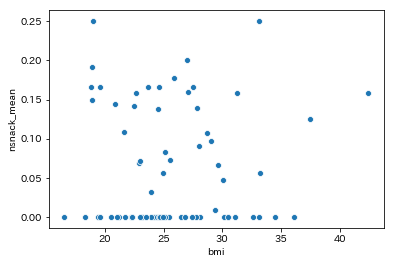

In [44]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', data = df[df.gender == 'male'])

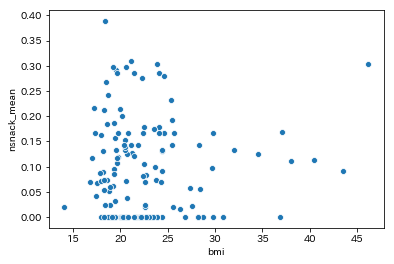

In [45]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', data = df[df.gender == 'female'])

## 目の乾き

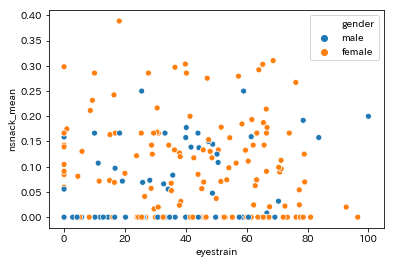

In [46]:
sns.scatterplot(x = 'eyestrain', y = 'nsnack_mean', hue= 'gender',data = df)

## 目の疲れ

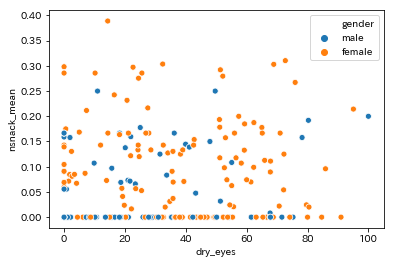

In [47]:
sns.scatterplot(x = 'dry_eyes', y = 'nsnack_mean', hue= 'gender',data = df)

## 幸福度

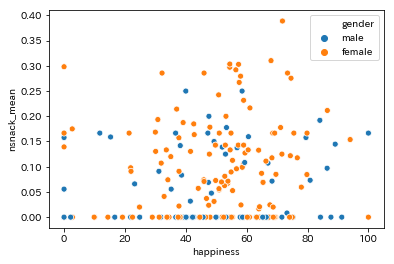

In [48]:
sns.scatterplot(x = 'happiness', y = 'nsnack_mean', hue= 'gender',data = df)

## 疲労感

In [49]:
df.describe()['nsnack_mean']

count    212.000000
mean       0.083508
std        0.089831
min        0.000000
25%        0.000000
50%        0.068096
75%        0.143327
max        0.388889
Name: nsnack_mean, dtype: float64

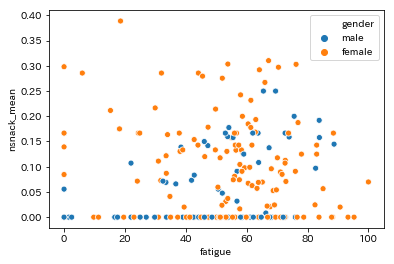

In [50]:
sns.scatterplot(x = 'fatigue', y = 'nsnack_mean', hue= 'gender',data = df)

Text(0.5, 1.0, 'fatigue - cumsum of nsnack_mean orderby fatigue')

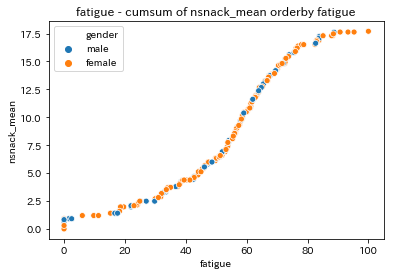

In [51]:
ax = sns.scatterplot(x = df.fatigue, y = df.sort_values('fatigue').nsnack_mean.cumsum(), hue = df.gender)
ax.set_title('fatigue - cumsum of nsnack_mean orderby fatigue')

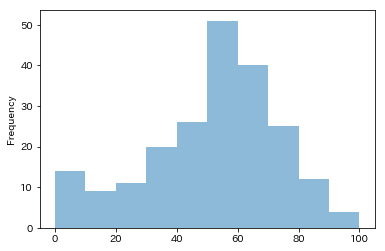

In [52]:
df.fatigue.plot(kind = 'hist', alpha =0.5)

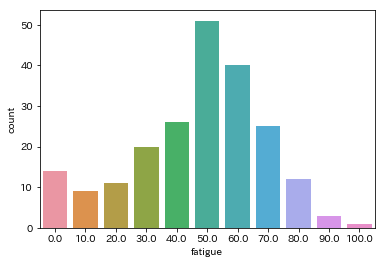

In [53]:
sns.countplot(df.fatigue.apply(lambda value: np.floor(value/10)*10))

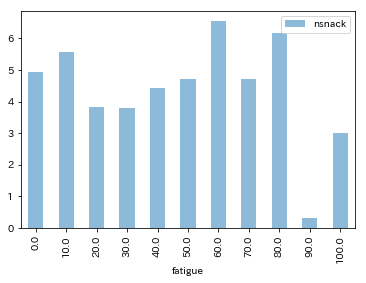

In [101]:
df.groupby(df.fatigue.apply(lambda value: np.floor(value/10)*10)).nsnack.mean().to_frame().plot(kind = 'bar', alpha = 0.5)

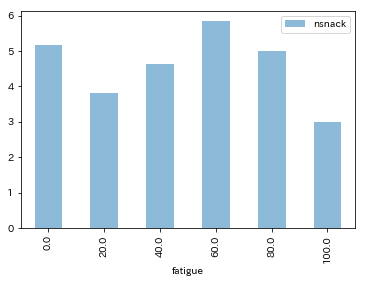

In [104]:
df.groupby(df.fatigue.apply(lambda value: np.floor(value/20)*20)).nsnack.mean().to_frame().plot(kind = 'bar', alpha = 0.5)

ボリュームゾーンなだけかな？

In [54]:
df.columns

Index(['user_id', 'gender', 'age', 'age_per_10', 'bmi', 'bmi_rank_3',
       'dry_eyes', 'eyestrain', 'happiness', 'fatigue', 'nsnack', 'ndate',
       'nsnack_mean'],
      dtype='object')

null model

In [55]:
model_null = smf.poisson('nsnack_mean ~ 1', data =df)
result_null = model_null.fit()

Optimization terminated successfully.
         Current function value: 0.253867
         Iterations 1


In [56]:
result_null.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Poisson
===============================================================
Model:              Poisson          Pseudo R-squared: 0.000   
Dependent Variable: nsnack_mean      AIC:              109.6397
Date:               2019-05-08 03:04 BIC:              112.9963
No. Observations:   212              Log-Likelihood:   -53.820 
Df Model:           0                LL-Null:          -53.820 
Df Residuals:       211              LLR p-value:      nan     
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     1.0000                                     
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept  -2.4828    0.2377  -10.4466  0.0000  -2.9486  -2.0170
===============================================================

"""

疲労感のみ

In [57]:
model_fatigue = smf.poisson('nsnack_mean ~ fatigue', data =df)
result_fatigue = model_fatigue.fit()

Optimization terminated successfully.
         Current function value: 0.253843
         Iterations 4


In [58]:
result_fatigue.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Poisson
===============================================================
Model:              Poisson          Pseudo R-squared: 0.000   
Dependent Variable: nsnack_mean      AIC:              111.6292
Date:               2019-05-08 03:04 BIC:              118.3424
No. Observations:   212              Log-Likelihood:   -53.815 
Df Model:           1                LL-Null:          -53.820 
Df Residuals:       210              LLR p-value:      0.91868 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -2.5404    0.6160  -4.1240  0.0000  -3.7478  -1.3330
fatigue      0.0011    0.0109   0.1018  0.9189  -0.0202   0.0224
===============================================================

"""

もう少し色々入れる

In [59]:
model = smf.poisson('nsnack_mean ~ age + bmi + dry_eyes + eyestrain + fatigue', data =df)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.253431
         Iterations 5


In [60]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Poisson
===============================================================
Model:              Poisson          Pseudo R-squared: 0.002   
Dependent Variable: nsnack_mean      AIC:              119.4550
Date:               2019-05-08 03:04 BIC:              139.5945
No. Observations:   212              Log-Likelihood:   -53.727 
Df Model:           5                LL-Null:          -53.820 
Df Residuals:       206              LLR p-value:      0.99927 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
----------------------------------------------------------------
Intercept    -2.2387    1.3279  -1.6859  0.0918  -4.8413  0.3639
age          -0.0080    0.0205  -0.3909  0.6959  -0.0481  0.0321
bmi           0.0008    0.0472   0.0175  0.9860  -0.0917  0.0934
dry_eyes      0.0028    0.0219   0.1266  0.8993  -0.0401  0.0456
eyestrain    -0.0025    0.0249  -0.1019  0.9188  -0.0513  0.0463
fatigue       0.0007    0.0148   0.0467  0.9628  -0.0284  0.0297
===============================================================

"""

雑すぎる？　

# 夕食後間食回数

In [61]:
data.head()

,user_id,data_type,time,time_date,sleep_at,next_wake_up_date,next_wake_up_at,next_first_meal_time,gender,age,age_per_10,bmi,bmi_rank,elapsed_time,is_lastday,is_lastday_shifted,is_lastsleep,last_sleep_time,is_unless
0,16,wake_up,2018-07-31 05:24:54,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,324.900000,0.0,0.0,0,2018-08-09 23:58:00,0
1,16,breakfast,2018-07-31 07:01:58,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,421.966667,0.0,0.0,0,2018-08-09 23:58:00,0
2,16,lunch,2018-07-31 12:15:08,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,735.133333,0.0,0.0,0,2018-08-09 23:58:00,0
3,16,dinner,2018-07-31 19:09:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,1149.000000,0.0,0.0,0,2018-08-09 23:58:00,0
4,16,sleep,2018-08-01 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-01,NaN,NaN,male,43,40s,24.964946,normal3,1440.000000,0.0,0.0,0,2018-08-09 23:58:00,0


In [0]:
dinner_date = data[data.data_type == 'dinner'][['user_id','time_date','time']].copy()
dinner_date.columns = ['user_id','time_date','dinner_time']

In [0]:
# 夕食後の記録
df_after_dinner = pd.merge(data, dinner_date,on = ['user_id', 'time_date'],how='left')
df_after_dinner = df_after_dinner[df_after_dinner.time > df_after_dinner.dinner_time]

df_after_dinner: 夕食後の記録　

In [64]:
# ユーザーごとの夕食後の記録がある日数
df_after_dinner.groupby('user_id').time_date.count().ro_frame().reset_index().rename(columns = {'time_date':'ndate'})

AttributeError: ignored

In [0]:
df_snack_after_dinner = df_after_dinner[df_after_dinner.data_type == 'snack']

df_snack_after_dinner: 夕食後の間食

In [0]:
# ユーザごとの間食回数をカウント
nsnack_after = df_snack_after_dinner.groupby('user_id').time.count().to_frame().reset_index()
nsnack_after.columns = ['user_id', 'nsnack']

In [0]:
nsnack_after = pd.merge(nsnack_after, ndate, on = 'user_id')

In [0]:
users_nosnack_after = [user for user in df.user_id.values if user not in nsnack_mean_after.user_id.values]
nosnack_after = pd.DataFrame({'user_id': users_nosnack_after, 'nsnack':0})

In [0]:
# 夕食後間食ある人とない人のデータをくっつける
nsnack_after = pd.concat([nsnack_after, nosnack_after])

In [0]:
# ndateくっつける
nsnack_after = pd.merge(nsnack_after, ndate, on =['user_id'])

In [0]:
print(nosnack_after.user_id.nunique())
print(nsnack_after.user_id.nunique())

In [0]:
# 分析用
 df_after = pd.merge(info_with_q, nsnack_after, on = 'user_id', how= 'right')

In [0]:
df_after['nsnack_mean'] = df['nsnack']/df['ndate']

In [0]:
df_after.groupby('gender').describe()['nsnack_mean']

In [0]:
sns.distplot(df_after.nsnack_mean)

In [0]:
df_after.groupby(['gender']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True)

## 年代

In [0]:
df_after.groupby(['gender', 'age_per_10']).describe()['nsnack_mean']

In [0]:
df_after.groupby(['gender', 'age_per_10']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True);

In [0]:
sns.violinplot(x = 'age_per_10', y ='nsnack_mean', hue ='gender', data =df_after, order = ['20s', '30s', '40s', '50s'])

In [0]:
sns.scatterplot(x = 'age', y ='nsnack_mean', hue ='gender', data =df_after)

## BMI

In [0]:
df_after.groupby(['gender', 'bmi_rank_3']).describe()['nsnack_mean']

In [0]:
df_after.groupby(['gender', 'bmi_rank_3']).nsnack_mean.plot(kind = 'hist', alpha = 0.5, legend = True);

In [0]:
sns.violinplot(x = 'bmi_rank_3', y ='nsnack_mean', hue ='gender', data =df_after)

In [0]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', hue= 'gender',data = df_after)

In [0]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', data = df_after[df_after.gender == 'male'])

In [0]:
sns.scatterplot(x = 'bmi', y = 'nsnack_mean', data = df_after[df_after.gender == 'female'])

## 目の乾き

In [0]:
sns.scatterplot(x = 'eyestrain', y = 'nsnack_mean', hue= 'gender',data = df_after)

## 目の疲れ

In [0]:
sns.scatterplot(x = 'dry_eyes', y = 'nsnack_mean', hue= 'gender',data = df_after)

## 幸福度

In [0]:
sns.scatterplot(x = 'happiness', y = 'nsnack_mean', hue= 'gender',data = df_after)

## 疲労感

In [0]:
sns.scatterplot(x = 'fatigue', y = 'nsnack_mean', hue= 'gender',data = df_after)

In [0]:
sns.scatterplot(x = df_after.fatigue, y = df_after.sort_values('fatigue').nsnack_mean.cumsum())

In [0]:
sns.scatterplot(x = df_after[df_after.gender == 'male'].fatigue, y = df_after[df_after.gender == 'male'].sort_values('fatigue').nsnack_mean.cumsum())

In [0]:
sns.scatterplot(x = df_after[df_after.gender == 'female'].fatigue, y = df_after[df_after.gender == 'female'].sort_values('fatigue').nsnack_mean.cumsum())